# PyMC4 implementation of logistic regression with spike-slab prior

Here I analyze the data posted at [PyMC4 github #247](https://github.com/pymc-devs/pymc4/issues/247#issue-619766402) and code in [the same thread](https://github.com/pymc-devs/pymc4/issues/247#issuecomment-630556063) using [rrkarim/pymc4:ccb29d8](https://github.com/rrkarim/pymc4/commit/ccb29d859a174ba9fcc96a6a4cfc07b38d3c80e5).

We simulated a data-set containing 1,000 samples with observed binary response ($y \in \{0,1\}$), under logistic regression $\text{logit}(E(y)) = \alpha + X\beta$ where $X$ has 3 variables $x_1 \ne x_2 = x_3$, with effect $\beta_1 = 0, \beta_2 \ne 0, \beta_3 = 0$.

We model variable $j$'s effect using a spike slab prior, $\beta_j \sim \pi_{j} \delta_0 + (1 - \pi_{j}) N (\mu, \sigma^2)$. Due to simulation settings we expect posterior of $\pi$ is close to 0 for $x_1$. Since  $x_2$ and $x_3$ are identical, we expect posterior of $\pi$ also identical for $x_2$ and $x_3$, and are both 0.5.

The model is implemented in both PyMC3 and PyMC4. For PyMC3 implementation I follow largely from [this notebook](https://www.kaggle.com/melondonkey/bayesian-spike-and-slab-in-pymc3) but using here instead a uniform prior for intercept.

## Result summary

For PyMC4 implementation, posteriors are $\tilde{\pi}_{1} = 0.99$, $\tilde{\pi}_{2} = 0.63$, $\tilde{\pi}_{3} = 0.46$. It roughly makes sense for the 2nd and 3rd variables but the first one is way off because it is expected to be zero. The intercept, came back as a point mess in trace plot, is also completely wrong -- expected to be around zero but is simply a point mass now at the center of the uniform prior.

Despite a couple of warning messages, the PyMC3 implementation gives better result for $\tilde{\pi}_{2}$ and $\tilde{\pi}_{3}$ (closer to 0.5) but $\tilde{\pi}_{1}$ is a lot better as it is closer to zero the truth. The intercept is also roughly correct.

See below for more details.

## Data simulation

In [0]:
import numpy as np
def simulate_logistic(x, b):
    z = x.dot(b)
    p = 1/(1+np.exp(-z))
    return np.random.binomial(1., p).astype(np.float32)

def get_X(n,p,seed=999):
    np.random.seed(seed)
    x1 = np.random.binomial(1,p,n)
    x2 = np.random.binomial(1,p,n)
    x3 = x2
    return np.vstack([x1, x2, x3]).T.astype(np.float32)

seed = 999
b = [0,1,0]
X = get_X(1000,0.2,seed)
y = simulate_logistic(X,b)

In [0]:
X.shape

(1000, 3)

In [0]:
y.shape

(1000,)

### Some global parameters

In [0]:
iteration = 2000
tune_prop = 0.1
n_chain = 3
n_thread = 4

pi0 = 0.051366009925488
mu = 0.783230896500752
sigma = 0.816999481742865
lower = -2.94
upper = 0

## PyMC4 spike-slab logistic regression

In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import pymc4 as pm4
from pymc4.mcmc.samplers import NUTS, RandomWalkM

@pm4.model
def bvsr_pm4(y, X, pi0=0.5, mu=0, sigma=1, lower=-1, upper=1):
    xi = yield pm4.Bernoulli('xi', pi0 * tf.ones(X.shape[1], 'float32'))
    beta_offset = yield pm4.Normal('beta_offset', tf.zeros(X.shape[1], 'float32'), tf.ones(X.shape[1], 'float32'))
    beta = yield pm4.Deterministic("beta", mu + beta_offset * sigma)
    alpha_offset = yield pm4.Uniform("alpha_offset", -1, 1)
    alpha = yield pm4.Deterministic("alpha", lower + (alpha_offset + 1) / 2 * (upper - lower))
    # this is the line in question; without explicit casting,
    # p = tf.linalg.matvec(X,  xi * beta)
    # will not work
    p = tf.linalg.matvec(X, tf.cast(xi, tf.float32) * beta)
    yield pm4.Bernoulli('y_obs', tf.math.sigmoid(p+alpha), observed = y)

tf.config.threading.set_intra_op_parallelism_threads(n_thread)

m4 = bvsr_pm4(y, tf.constant(X), pi0, mu, sigma, lower, upper)
trace4 = pm4.sample(
        m4, step_size=0.01, num_chains=n_chain, num_samples=iteration,
        burn_in=int(tune_prop*iteration), nuts_kwargs={},
        xla=False, use_auto_batching=True,
        sampler_type="compound", 
        sampler_methods=[
        ("xi", RandomWalkM), 
        ("beta", NUTS),
        ("alpha", NUTS),
        ("beta_offset", NUTS),
        ("alpha_offset", NUTS)
        ]
    )

## PyMC3 spike-slab logistic regression

In [0]:
import pymc3 as pm3
import theano.tensor as tt

def bvsr_pm3(y, X, pi0=0.5, mu=0, sigma=1, lower=-1, upper=1):
    invlogit = lambda x: 1/(1 + tt.exp(-x))
    model = pm3.Model()
    with model:
        xi = pm3.Bernoulli('xi', pi0, shape = X.shape[1])
        beta_offset = pm3.Normal('beta_offset', mu = 0, sd = 1, shape = X.shape[1])
        beta = pm3.Deterministic("beta", mu + beta_offset * sigma)
        alpha_offset = pm3.Uniform("alpha_offset", lower = -1, upper = 1)
        alpha = pm3.Deterministic("alpha", lower + (alpha_offset+1)/2*(upper - lower))
        p = pm3.math.dot(X, xi * beta)
        y_obs = pm3.Bernoulli('y_obs', invlogit(p + alpha), observed = y)
    return model

m3 = bvsr_pm3(y,X, pi0, mu, sigma, lower, upper)
target_accept = 0.95

with m3:
    trace3 = pm3.sample(draws = iteration, random_seed = seed, cores = n_thread, progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [alpha_offset, beta_offset]
Sampling 3 chains, 0 divergences: 100%|██████████| 6600/6600 [00:12<00:00, 543.20draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## PyMC4 result

### Trace

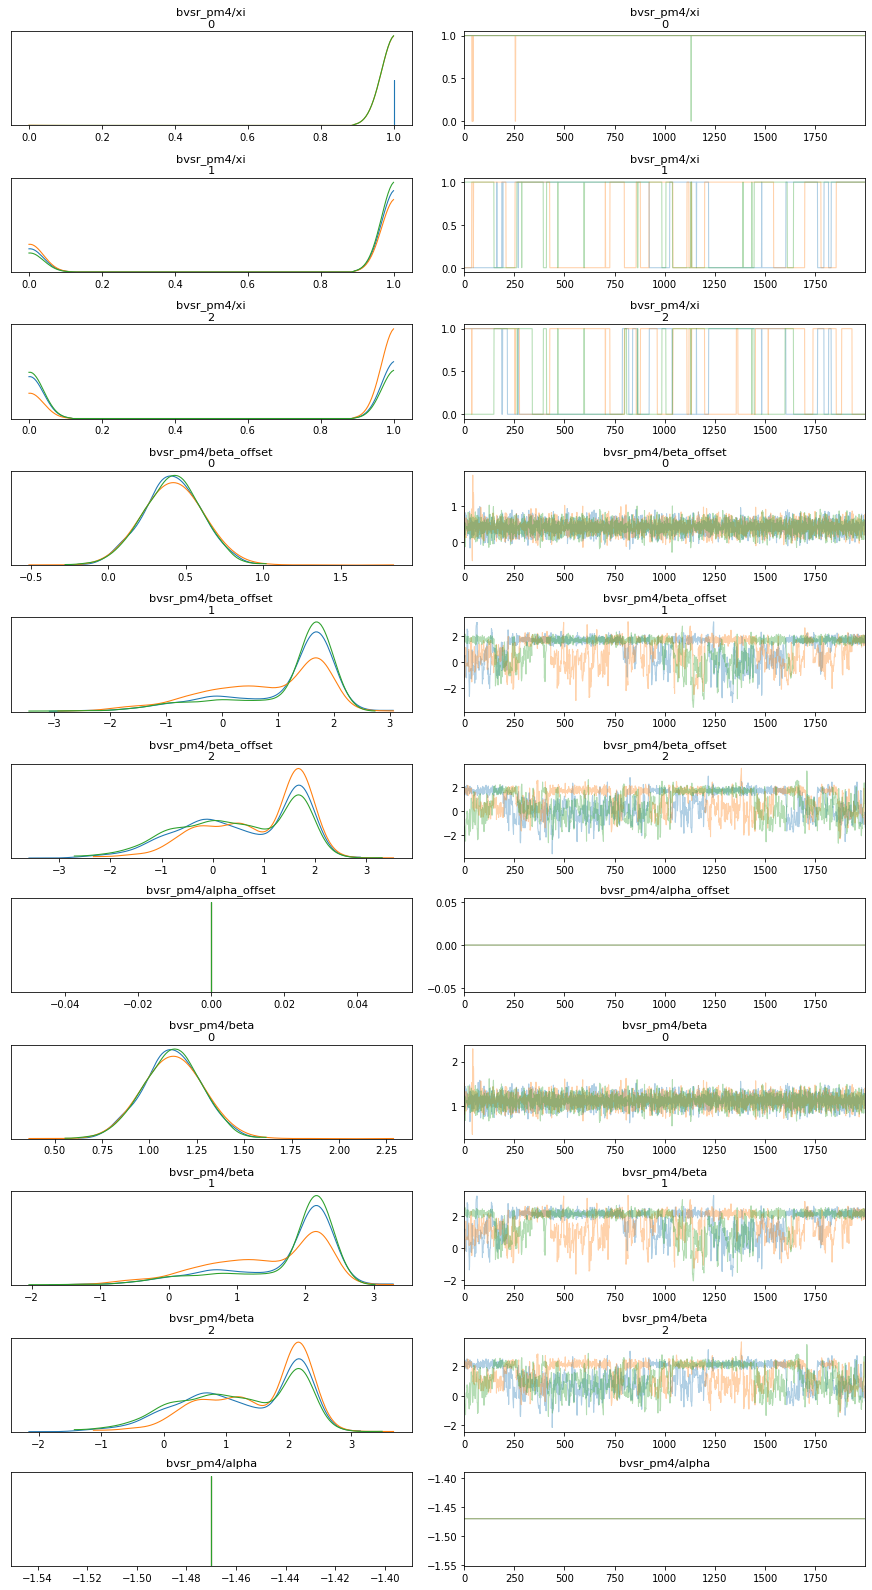

In [0]:
import arviz as az
status = az.plot_trace(trace4)

### Posterior estimate of $\pi$

We expect them to be (0, 0.5, 0.5)

In [0]:
xi = np.array(trace4.posterior['bvsr_pm4/xi'])
np.mean(np.mean(xi, axis=1), axis=0)

array([0.9983334 , 0.6375    , 0.46416664], dtype=float32)

### Posterior estimate of $\alpha$
We expect it be 0.

In [0]:
alpha = np.array(trace4.posterior['bvsr_pm4/alpha'])
np.mean(alpha)

-1.4700003

## PyMC3 result

### Trace

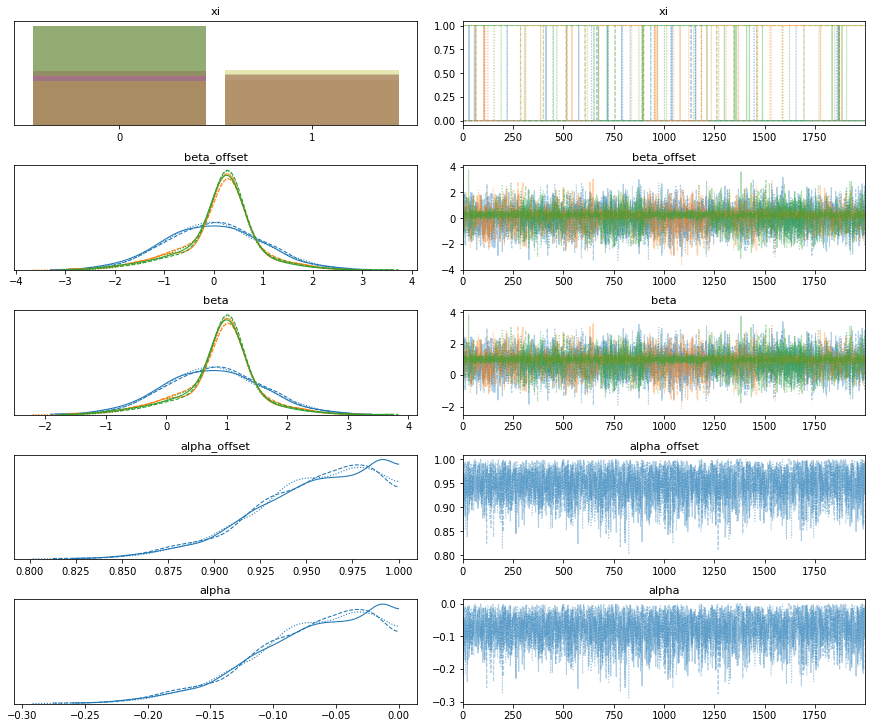

In [0]:
status = pm3.traceplot(trace3)

### Posterior estimate of $\pi$

We expect them to be (0, 0.5, 0.5)

In [0]:
np.apply_along_axis(np.mean, 0, trace3['xi'])

array([0.00516667, 0.49      , 0.52533333])

### Posterior estimate of $\alpha$
We expect it be 0.

In [0]:
np.mean(trace3['alpha'])

-0.07100071659965644